In [327]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

M0: 8.149e+08 V
T2_star: 6.483e-07 ms


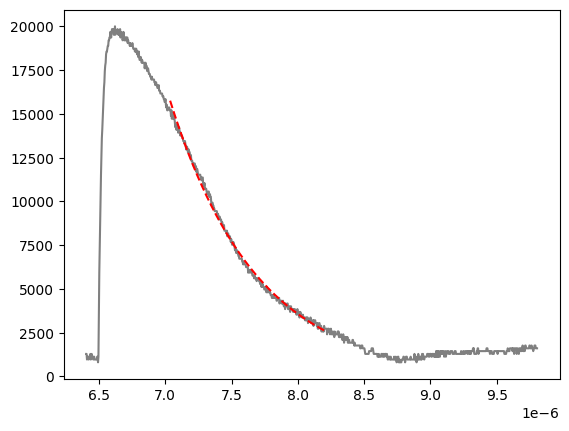

In [328]:
dataframe = read_csv("T2_stern_01.csv", names=["Tau","Volt"])    
dataframe.drop(dataframe.index[[0,1,2]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
x, y = data[2000:-1000, 0], data[2000:-1000, 1]

# adjust units
x *= 8e8 * 1e-12
y *= 2e6 * 1e-6

# Trim out noise and start from max + trim_front
trim_front = 130
trim_back = 500

maxindex = np.where(y == max(y))[0][0]
x_trim, y_trim = x[maxindex+trim_front:-trim_back], y[maxindex+trim_front:-trim_back]

# define the true function
def T2_function(t, M0, T2_star):
	return M0 * np.exp(-t / T2_star)

# Do the fit
initialguess = 1e7 *2 , 0.001 * (8e8 * 1e-12)
(M0, T2_star ), _ = curve_fit(T2_function, x_trim, y_trim, initialguess)

# Plot result
x_fit_line = np.linspace(min(x_trim), max(x_trim), num=1000)
y_fit_line = T2_function(x_fit_line, M0, T2_star)
plt.plot(x,y, c='gray')
plt.plot(x_fit_line, y_fit_line, '--', c='red')
print(f"M0: {M0:.3e} V\nT2_star: {T2_star:.3e} ms")

# Finding $T_1$

Text(0.5, 0, 'Time after initial pulse $\\tau$ [ms]')

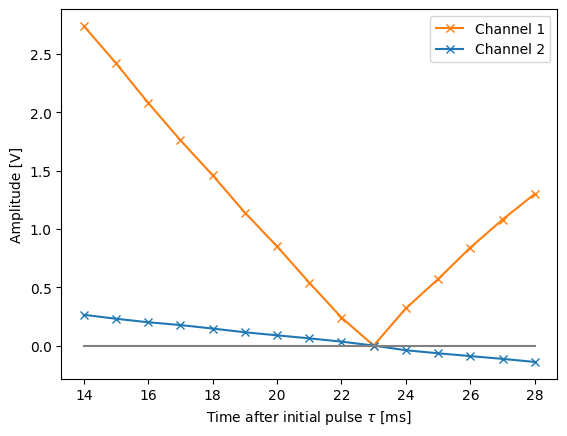

In [329]:
dataframe = read_csv("T1.csv", names=["Tau","VYellow", "VBlue"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
x, yYellow, yBlue = data[:, 0], data[:, 1], data[:, 2]

plt.plot(x, yYellow, marker = 'x', color="C1", label="Channel 1")
plt.plot(x, yBlue, marker='x', color="C0", label="Channel 2")
plt.plot([min(x),max(x)],[0,0], color="gray")
plt.legend()
plt.ylabel("Amplitude [V]")
plt.xlabel(r"Time after initial pulse $\tau$ [ms]")

# $T_2^*$ vs $T_2$

M0: 8.878e+00 V
T2: 1.114e+01 ms


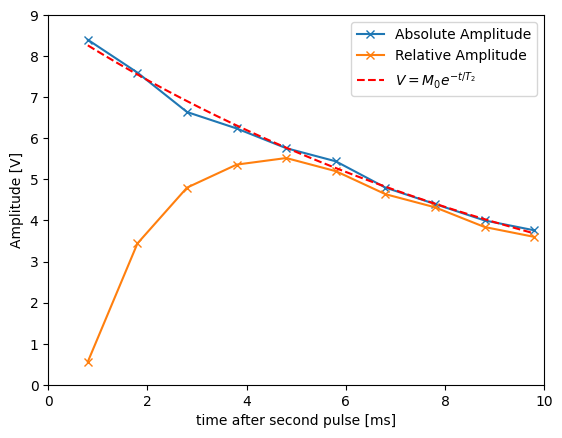

In [334]:
dataframe = read_csv("T2_star_vs_T2.csv", names=["Tau","V_abs", "V_pure"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
x, yAbs, yPure = data[:, 0], data[:, 1], data[:, 2]


# define the true function
def T2_function(t, M0, T2):
	return M0 * np.exp(-t / T2)

# Do the fit
initialguess = 1, 1
(M0, T2 ), _ = curve_fit(T2_function, x, yAbs, initialguess)

# Plot result
x_fit_line = np.linspace(min(x), max(x), num=1000)
y_fit_line = T2_function(x_fit_line, M0, T2)

plt.plot(x, yAbs, marker='x', label="Absolute Amplitude")
plt.plot(x, yPure, marker = 'x', label="Relative Amplitude")
plt.plot(x_fit_line, y_fit_line, '--', c='red', label=r"$V = M_0 e^{-t / T_2}$")

plt.ylim(0, 9)
plt.xlim(0, 10)
plt.ylabel("Amplitude [V]")
plt.xlabel("time after second pulse [ms]")
plt.legend()

print(f"M0: {M0:.3e} V\nT2: {T2:.3e} ms")

# MG On/Off

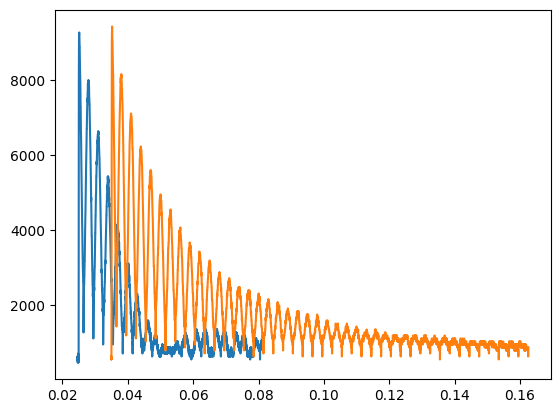

In [331]:
dataframeOn = read_csv("MultiplePulses_MG_ON.csv", names=["Tau","Volt"])    
dataframeOn.drop(dataframeOn.index[[0,1,2]], inplace=True)
dataframeOn = dataframeOn.astype(float)

dataframeOff = read_csv("MultiplePulses_MG_OFF.csv", names=["Tau","Volt"])    
dataframeOff.drop(dataframeOff.index[[0,1,2]], inplace=True)
dataframeOff = dataframeOff.astype(float)

xOff, yOff = dataframeOff.values[1228:, 0], dataframeOff.values[1228:, 1]
xOn, yOn = dataframeOn.values[871:, 0], dataframeOn.values[871:, 1]

plt.plot(xOff, yOff)
plt.plot(xOn, yOn)

a: 1.210636e+06
b: 4.243376e-02
c: -1.824432e-01


/home/benjaminorthner/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


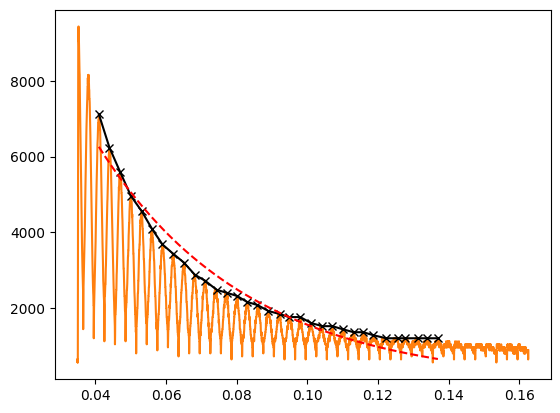

In [332]:
# Find peaks (needed to plot envelope)
peaksOn = find_peaks(yOn, threshold=0, distance=50)[0]

xPeakOn = [xOn[i] for i in peaksOn][2:-10]
yPeakOn = [yOn[i] for i in peaksOn][2:-10]

plt.plot(xOn, yOn, c="C1")
plt.plot(xPeakOn, yPeakOn, c="black", marker="x")

def exp_function(x, a, b, c):
    return a*np.exp(-(x-c) / b)

# Do the fit
initialguess = 9e4, 0.01, 0.001
(a, b, c), _ = curve_fit(exp_function, xPeakOn, yPeakOn, initialguess)

# Plot result
x_fit_line = np.linspace(min(xPeakOn), max(xPeakOn), num=1000)
y_fit_line = exp_function(x_fit_line, a, b, c)

plt.plot(x_fit_line, y_fit_line, '--', c='red')

print(f"a: {a:e}\nb: {b:e}\nc: {c:e}")
    

a: 9.813081e+04
b: 1.326536e-02
c: -5.532140e-03


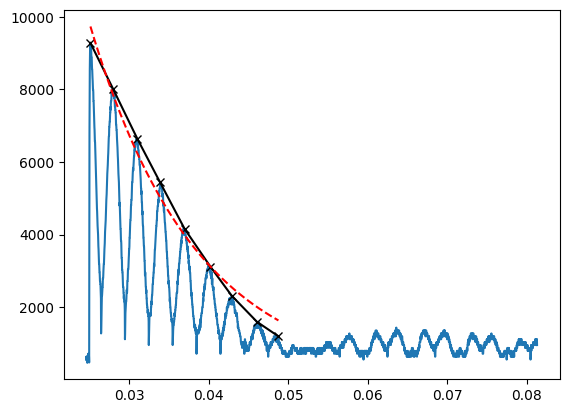

In [333]:
peaksOff = find_peaks(yOff, threshold=0, distance=100)[0]

xPeakOff = [xOff[i] for i in peaksOff][:-11]
yPeakOff = [yOff[i] for i in peaksOff][:-11]

plt.plot(xOff, yOff, c="C0")
plt.plot(xPeakOff, yPeakOff, c="black", marker="x")

# Do the fit
initialguess = 9e4, 0.01, 0.001
(a, b, c), _ = curve_fit(exp_function, xPeakOff, yPeakOff, initialguess)

# Plot result
x_fit_line = np.linspace(min(xPeakOff), max(xPeakOff), num=1000)
y_fit_line = exp_function(x_fit_line, a, b, c)

plt.plot(x_fit_line, y_fit_line, '--', c='red')

print(f"a: {a:e}\nb: {b:e}\nc: {c:e}")
    